In [20]:
from dasly import das_master
import numpy as np
import pandas as pd
import os

In [13]:
def find_hdf5(folder_path: str) -> list[str]:
    """All hdf5 files in a folder.

    Args:
        folder_path (str): Folder path.

    Returns:
        list[str]: List of file paths,
    """
    file_paths = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_paths.append(os.path.join(root, file))
    file_paths = [file for file in file_paths if file.endswith('.hdf5')]
    file_paths.sort()
    return file_paths

In [17]:
file_paths = find_hdf5('/mnt/Datastore/usr/kptruong/dasly_repo/data/Svalbard_whale/20220822')
file_paths = file_paths[49+3:49+6]
file_paths

['/mnt/Datastore/usr/kptruong/dasly_repo/data/Svalbard_whale/20220822/dphi/122839.hdf5',
 '/mnt/Datastore/usr/kptruong/dasly_repo/data/Svalbard_whale/20220822/dphi/122849.hdf5',
 '/mnt/Datastore/usr/kptruong/dasly_repo/data/Svalbard_whale/20220822/dphi/122859.hdf5']

In [22]:
das = das_master.Dasly()
das.load_data(
    folder_path='/mnt/Datastore/usr/kptruong/dasly_repo/data/Svalbard_whale',
    start='20220822 122839',
    duration=30
)

4 files, from 122839 to 122909


In [9]:
# folder_path = '/mnt/Datastore/usr/kptruong/Svalbard_whale/dphi_1220'
folder_path = '/mnt/Datastore/usr/kptruong/Svalbard_whale/20220822'
file_paths = helper.find_hdf5(folder_path)
# file_paths = file_paths[8:8+6]
# file_paths = file_paths[0:6]
file_paths = file_paths[49+3:49+6]
file_paths

NameError: name 'helper' is not defined

ValueError: The function accepts two and only two out of three (start, end, duration)

In [20]:
# das.signal = das.signal.loc[:, 50000:97500]
das.signal = das.signal.loc[:, 50000:70000]

Signal updated with band-pass filter.


(18750, 5001)


vmin: -2.99e-08, vmax: 2.99e-08


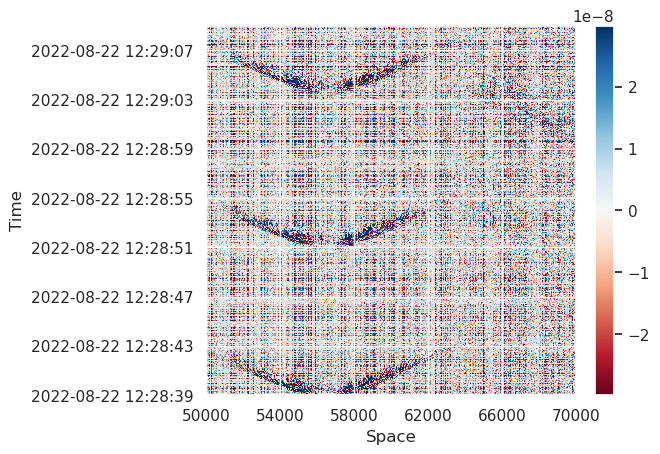

In [21]:
das.bandpass_filter(15, 25)
print(das.signal.shape)
das.heatmap()

Signal updated with new temporal sampling rate 2e+01 and new spatial sampling rate 0.01.
vmin: -6.07e-10, vmax: 6.07e-10


(750, 201)


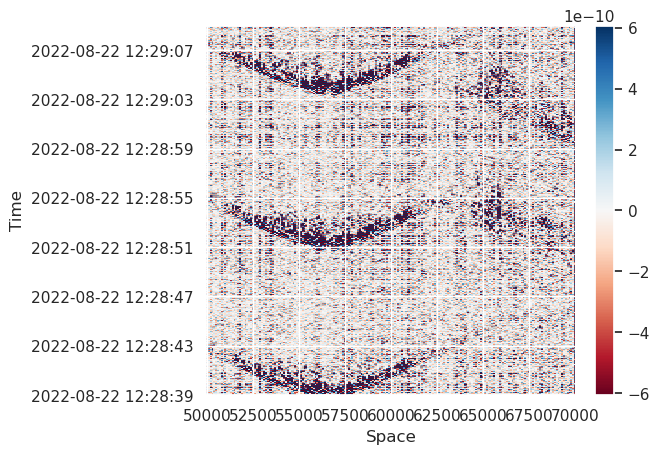

In [22]:
das.sample(meters=100, seconds=1/25, func_name='mean')
print(das.signal.shape)
das.heatmap()

Signal updated with Gaussian smoothing.
vmax: 3.89e-10


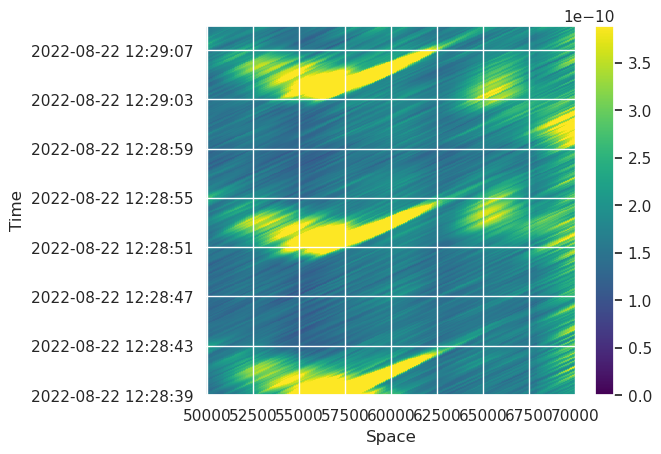

In [23]:
das.signal = np.abs(das.signal)
das.gaussian_smooth(1500, 1500.01, unit='m/s', std_s=1000)
das.heatmap()

vmax: 0.00198


(69, 41)
25.0
0.01


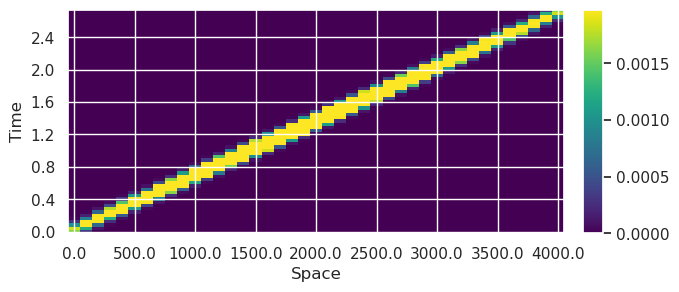

In [24]:
print(das.gauss_kernel.shape)
print(das.t_rate)
print(das.s_rate)
das.heatmap(
    das.gauss_kernel,
    aspect=das.signal.shape[1]/das.signal.shape[0]
)

Signal updated with Sobel filter.
vmax: 1.78e-10


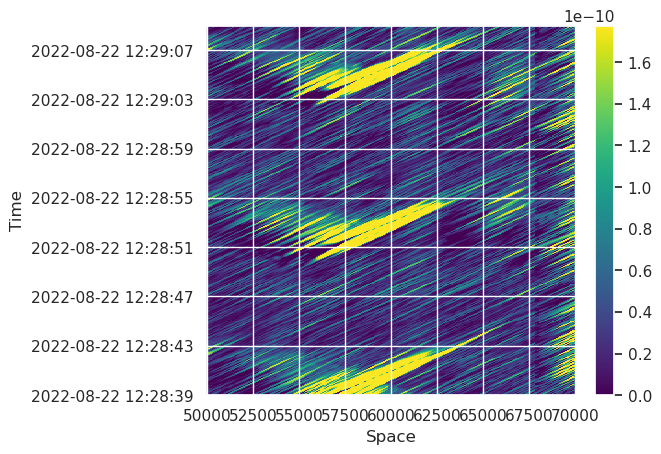

In [25]:
das.sobel_filter()
das.heatmap()

Signal updated with binary transform with threshold 1.78e-10.


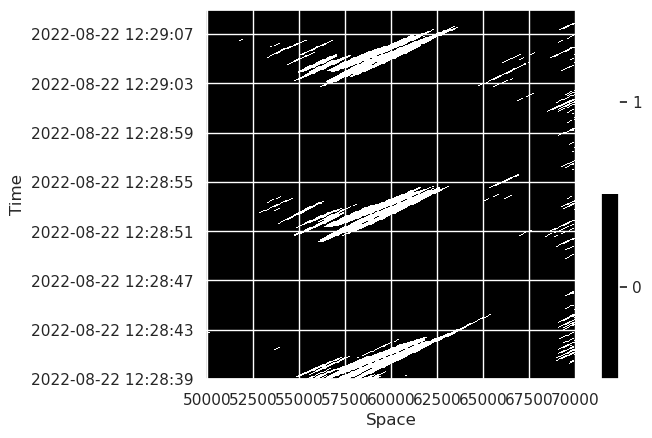

In [26]:

das.binary_transform(0.95)
das.heatmap()

20 lines are detected.


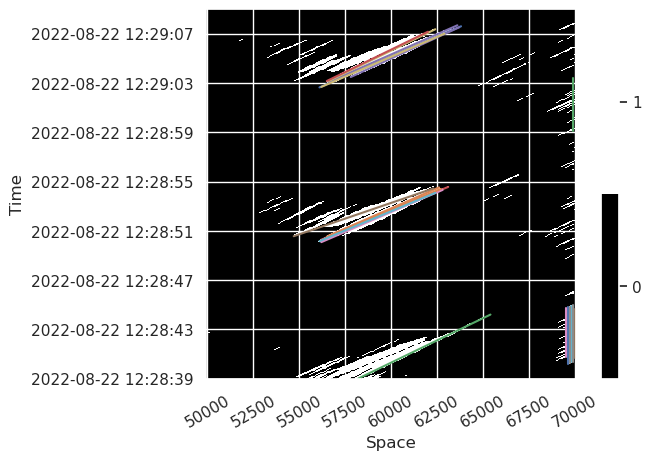

In [30]:
das.hough_transform(target_speed=1500, speed_res=10, length_meters=5000, speed_unit='m/s')
das.heatmap(xticks_rotate=30)

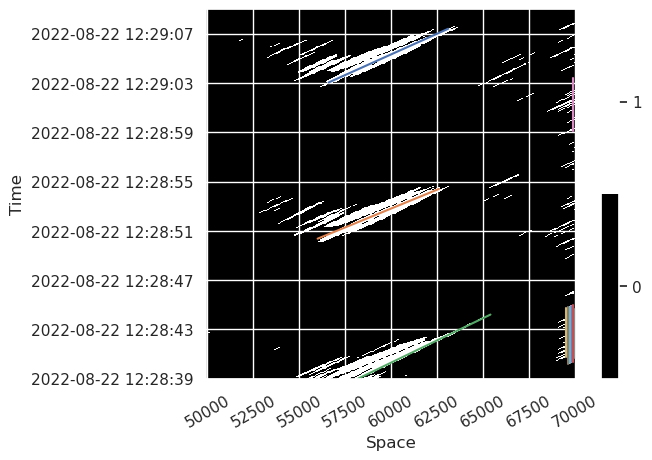

In [31]:
das.dbscan(eps_seconds=1)
das.heatmap(xticks_rotate=30)

In [32]:
das.lines_df

,speed_kmh,speed_ms,s,t,s1,t1,s2,t2,s1_edge,t1_edge,...,x1,y1,x2,y2,x1_edge,y1_edge,x2_edge,y2_edge,y1_edge_ext,y2_edge_ext
0,5366.972477,1490.825688,6500.0,4.36,56600.0,2022-08-22 12:29:03.040,63100.0,2022-08-22 12:29:07.400,50000.0,2022-08-22 12:28:58.612923077,...,66.0,601.0,131.0,710.0,0.0,490.323077,154.256881,749.000000,490.323077,825.707692
1,5881.188119,1633.663366,6600.0,4.04,56000.0,2022-08-22 12:28:50.360,62600.0,2022-08-22 12:28:54.400,50000.0,2022-08-22 12:28:46.687272727,...,60.0,284.0,126.0,385.0,0.0,192.181818,200.000000,498.242424,192.181818,498.242424
2,4984.615385,1384.615385,7200.0,5.20,58200.0,2022-08-22 12:28:39.000,65400.0,2022-08-22 12:28:44.200,58200.0,2022-08-22 12:28:39.000000000,...,82.0,0.0,154.0,130.0,82.0,0.000000,200.000000,213.055556,-148.055556,213.055556
3,0.000000,0.000000,0.0,4.64,69900.0,2022-08-22 12:28:40.360,69900.0,2022-08-22 12:28:45.000,NaN,NaT,...,199.0,34.0,199.0,150.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,0.000000,0.0,4.60,69800.0,2022-08-22 12:28:40.320,69800.0,2022-08-22 12:28:44.920,NaN,NaT,...,198.0,33.0,198.0,148.0,NaN,NaN,NaN,NaN,NaN,NaN
5,0.000000,0.000000,0.0,4.60,69600.0,2022-08-22 12:28:40.200,69600.0,2022-08-22 12:28:44.800,NaN,NaT,...,196.0,30.0,196.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN
6,0.000000,0.000000,0.0,4.32,69900.0,2022-08-22 12:28:59.080,69900.0,2022-08-22 12:29:03.400,NaN,NaT,...,199.0,502.0,199.0,610.0,NaN,NaN,NaN,NaN,NaN,NaN
7,0.000000,0.000000,0.0,3.96,70000.0,2022-08-22 12:28:40.680,70000.0,2022-08-22 12:28:44.640,NaN,NaT,...,200.0,42.0,200.0,141.0,NaN,NaN,NaN,NaN,NaN,NaN
8,0.000000,0.000000,0.0,3.96,69500.0,2022-08-22 12:28:40.760,69500.0,2022-08-22 12:28:44.720,NaN,NaT,...,195.0,44.0,195.0,143.0,NaN,NaN,NaN,NaN,NaN,NaN
9,0.000000,0.000000,0.0,4.60,69700.0,2022-08-22 12:28:40.240,69700.0,2022-08-22 12:28:44.840,NaN,NaT,...,197.0,31.0,197.0,146.0,NaN,NaN,NaN,NaN,NaN,NaN
